# NOTEBOOK 5 - Electromagnetic Phenomena | Large Disturbances

#### A quick introduction ...

Still a work in progress, if there is anything missing or you have some general feedback please contact Sjur Føyen at foyen.sjur@ntnu.no 

Outline of notebook:
- Outline


Code implemented by; HARALD. Date; 31.01.2025

Last update; 31.01.2025

GitHub Copilot used for assistance in coding.

In [1]:
%pip install git+https://github.com/hallvar-h/tops

import sys
from collections import defaultdict
import matplotlib.pyplot as plt
import time

# Solver and dynamic models
from tops import dynamic as dps
from tops import solvers as dps_sol
#from tops.ps_models import ieee39

  Cloning https://github.com/hallvar-h/tops to /private/var/folders/8x/_s0cs76d26541h_f7wd81_n40000gn/T/pip-req-build-um8e63a1
  Running command git clone --filter=blob:none --quiet https://github.com/hallvar-h/tops /private/var/folders/8x/_s0cs76d26541h_f7wd81_n40000gn/T/pip-req-build-um8e63a1
  Resolved https://github.com/hallvar-h/tops to commit 2daedbf4daca07d8c1e644d433a3fb27896ffbb4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tops: filename=tops-0.2.0-py3-none-any.whl size=53948 sha256=e360fdb02bcbe8fea264e41bdfe6364922106fada4da363aa839dc206fd492f0
  Stored in directory: /private/var/folders/8x/_s0cs76d26541h_f7wd81_n40000gn/T/pip-ephem-wheel-cache-z2xe5sew/wheels/81/46/3e/1d6b62898063f8070dd6228059a37a42a911a5d7b6f6ed5377
Successfully built tops
Note: you may need to restart the kernel to use updated packages.


In [2]:
def load_assignment_model():
    return {
        'base_mva': 50, #'base_mva': system base/nominal complex power in [MVA].
        'f': 50, #'f': system frequency in [Hz].
        'slack_bus': 'B3', #'slack_bus': reference busbar with zero phase angle.

        'buses': [
            ['name',    'V_n'],
            ['B1',         10],
            ['B2',        245],
            ['B3',        245],
        ],
        #'V_n': base/nominal voltage in [kV].

        'lines': [
            ['name',  'from_bus', 'to_bus',   'length',   'S_n',  'V_n',  'unit', 'R',    'X',   'B'],
            ['L2-3',        'B2',     'B3',        250,      50,    245,    'PF',   0,    0.4,     0],
        ],
        #'length': total line length in [km].
        #'S_n': base/nominal complex power in [MVA].
        #'V_n': base/nominal voltage in [kV].
        #'unit': chosen unit for jacobian admittance calculation (leave it as 'PF').
        #'R': line resistance in [Ohm/km].
        #'X': line reactance in [Ohm/km].
        #'B': line susceptance in [Ohm/km].

        'transformers': [
            ['name', 'from_bus', 'to_bus', 'S_n', 'V_n_from', 'V_n_to', 'R', 'X'],
            ['T1',         'B1',     'B2',    50,         10,      245,   0, 0.1],
        ],
        #'S_n': base/nominal complex power in [MVA].
        #'V_n_from': base/nominal voltage on the 'from_bus' side in [kV].
        #'V_n_to': base/nominal voltage on the 'to_bus' side in [kV].
        #'R': transformer resistance in [pu].
        #'X': transformer reactance in [pu].

        'loads': [
            ['name', 'bus', 'P', 'Q', 'model'],
            ['L1',    'B2',  25,   0,     'Z'],
        ],
        #'P': active power delivered to the load in [MW].
        #'Q': reactive power delivered to the load in [MVAr].
        #'model': modelling of load voltage dependence (leave it as 'Z').

        'generators': {
            'GEN': [
                ['name',   'bus',  'S_n',  'V_n',    'P',    'V',      'H',    'D',    'X_d',  'X_q',  'X_d_t',    'X_q_t',    'X_d_st',   'X_q_st',   'T_d0_t',   'T_q0_t',   'T_d0_st',  'T_q0_st'],
                ['G1',      'B1',     50,     10,     40,  0.933,      3.1,      0,     1.05,   0.66,    0.328,      0.66,       0.254,      0.273,       2.49,      10000,         0.06,       0.15],
                ['IB',      'B3',    1e8,    245,    -15,  0.898,      1e5,      0,     1.05,   0.66,    0.328,      0.66,       0.254,      0.273,       2.49,      10000,         0.06,       0.15],
            ],
        },
        # For 'IB': change only 'V_n', 'P' and 'V' if necessary. Other parameters should be left as they are.

        # 'S_n': base/nominal complex power in [MVA].
        # 'V_n': base/nominal voltage in [kV].
        # 'P': active power produced by the generator in [MW].
        # 'V': magnitude of generator terminal voltage in [pu].
        # 'H': inertia constant in [MWs/MVA].
        # 'D': damping constant in [pu-power/pu-speed].
        # 'X_d'/'X_q': synchronous d-axis/q-axis reactance in [pu].
        # 'X_d_t'/'X_q_t': transient d-axis/q-axis reactance in [pu].
        # 'X_d_st'/'X_q_st': subtransient d-axis/q-axis reactance in [pu].
        # 'T_d0_t'/'T_q0_t': open-circuit d-axis/q-axis transient time constant in [s].
        # 'T_d0_st'/'T_q0_st': open-circuit d-axis/q-axis subtransient time constant in [s].
    }

0.12484519754133339
99%Simulation completed in 1.14 seconds.


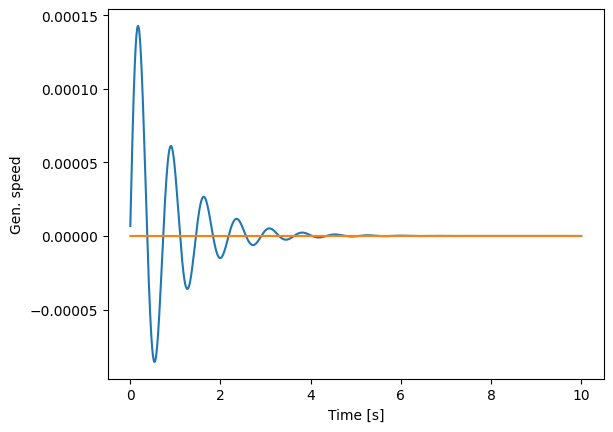

In [3]:
model = load_assignment_model()
# Power system model
ps = dps.PowerSystemModel(model=model)
ps.init_dyn_sim()
print(max(abs(ps.state_derivatives(0, ps.x_0, ps.v_0))))

t_end = 10
x_0 = ps.x_0.copy()

# Solver
sol = dps_sol.ModifiedEulerDAE(ps.state_derivatives, ps.solve_algebraic, 0, x_0, t_end, max_step=5e-3)

# Initialize simulation
t = 0
res = defaultdict(list)
t_0 = time.time()

sc_bus_idx = ps.gen['GEN'].bus_idx_red['terminal'][0]

# Run simulation
while t < t_end:
    sys.stdout.write("\r%d%%" % (t/(t_end)*100))

    ################  Assignment 3 / 4: Simulation of short-circuit  ################

    #if (...):
    #    ps.y_bus_red_mod[ , ] =
    #else:
    #    ps.y_bus_red_mod[ , ] =

    ##'y_bus_red_mod' refers to the fault admittance, the inverse of fault impedance.
    ##Fault: impedance = zero --> admittance = ?

    ##[0, 0]: corresponds to 'B1' (generator bus).
    ##[1, 1]: corresponds to 'B2' (load bus).
    ##[2, 2]: corresponds to 'B3' (stiff network).

    #################################################################################

    #####  Assignment 5/6: Short-circuit with line disconnection & reconnection #####

    #if (...) and (...):
    #   (...)
    #   ps.y_bus_red_mod[ , ] =

    #if (...) and (...):
    #    (...)
    #    ps.lines['Line'].event(ps, ps.lines['Line'].par['name'][0], 'disconnect')
    #    ps.y_bus_red_mod[ , ] =

    #if (...) and (...):
    #    (...)
    #    ps.lines['Line'].event(ps, ps.lines['Line'].par['name'][0], 'connect')

    #################################################################################

    # Simulate next step
    result = sol.step()
    x = sol.y
    v = sol.v
    t = sol.t

    dx = ps.ode_fun(0, ps.x_0)

    # Store result
    res['t'].append(t)
    res['gen_speed'].append(ps.gen['GEN'].speed(x, v).copy())

print('Simulation completed in {:.2f} seconds.'.format(time.time() - t_0))

plt.figure()
plt.plot(res['t'], res['gen_speed'])
plt.xlabel('Time [s]')
plt.ylabel('Gen. speed')
plt.show()